In [90]:
%load_ext autoreload
%autoreload 2
import matplotlib
from matplotlib import rcParams, rc
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import numpy as np
from astropy.table import Table, join
from astropy.io import fits
from tqdm import tqdm

import cmasher as cmr
cmap = cmr.dusk

from tqdm import tqdm
import joblib 

rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 8
rcParams['font.family'] = 'sans-serif'
%config InlineBackend.figure_format = "retina"

import sys
sys.path.append("/home/jdli/transpec")

import time
import os
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from kvxp.xpformer import XPformer, XPformer2, CNN
from kvxp.data import  GXP_AP_4lb, GXP_5lb, GXP_4lb, GXP_4lb_infer
from kvxp.utils import *
from kvxp.vis import draw_hist2d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
# df = Table.read("/data/jdli/gaia/HWR_for_Jiandong.fits").to_pandas()
df = pd.read_csv("/data/jdli/gaia/gaia_spec_20230303.csv", sep="|")
df_gmag = Table.read("/home/jdli/transpec/data/GaiaDR3_SID.fits").to_pandas()

df = df.merge(df_gmag, on='source_id')

print(df.shape, df.columns)

(660675, 6) Index(['source_id', 'bp_coefficient', 'rp_coefficients',
       'bp_coefficient_errors', 'rp_coefficient_errors', 'phot_g_mean_mag'],
      dtype='object')


In [ ]:
def recover_coef(series):
    return [list(map(float, s[1:-1].split(','))) for s in series]


def l2norm(y):
    return np.sqrt(np.sum(y**2, axis=1))

coef_names = ['bp_coefficient', 'bp_coefficient_errors', 
              'rp_coefficients', 'rp_coefficient_errors']

for col in coef_names:
    df[col] = recover_coef(df[col])
    
xp_coeff_array = np.zeros([4, len(df), 55])

for i in range(4):
    xp_coeff_array[i] = np.array([np.array(x) for x in df[coef_names[i]].values])


In [ ]:
bp_snr = np.abs(xp_coeff_array[0,:,:]/xp_coeff_array[1,:,:])
rp_snr = np.abs(xp_coeff_array[2,:,:]/xp_coeff_array[3,:,:])

plt.hist(np.log10(bp_snr.flatten()), histtype='step', bins=100, log=True);
plt.hist(np.log10(rp_snr.flatten()), histtype='step', bins=100, log=True);
plt.axvline(x=np.log10(3), c='k')
plt.axvline(x=np.log10(1), c='k')

In [ ]:
bp_scaler_name = "/home/jdli/transpec/models/scaler_bp_gmagand_0228.gz"
rp_scaler_name = "/home/jdli/transpec/models/scaler_rp_gmagand_0228.gz"
label_scaler_name = "/home/jdli/transpec/models/scaler_labels_0228.gz"


scaler_bp = joblib.load(bp_scaler_name)
scaler_rp = joblib.load(rp_scaler_name)
scaler_label = joblib.load(label_scaler_name)

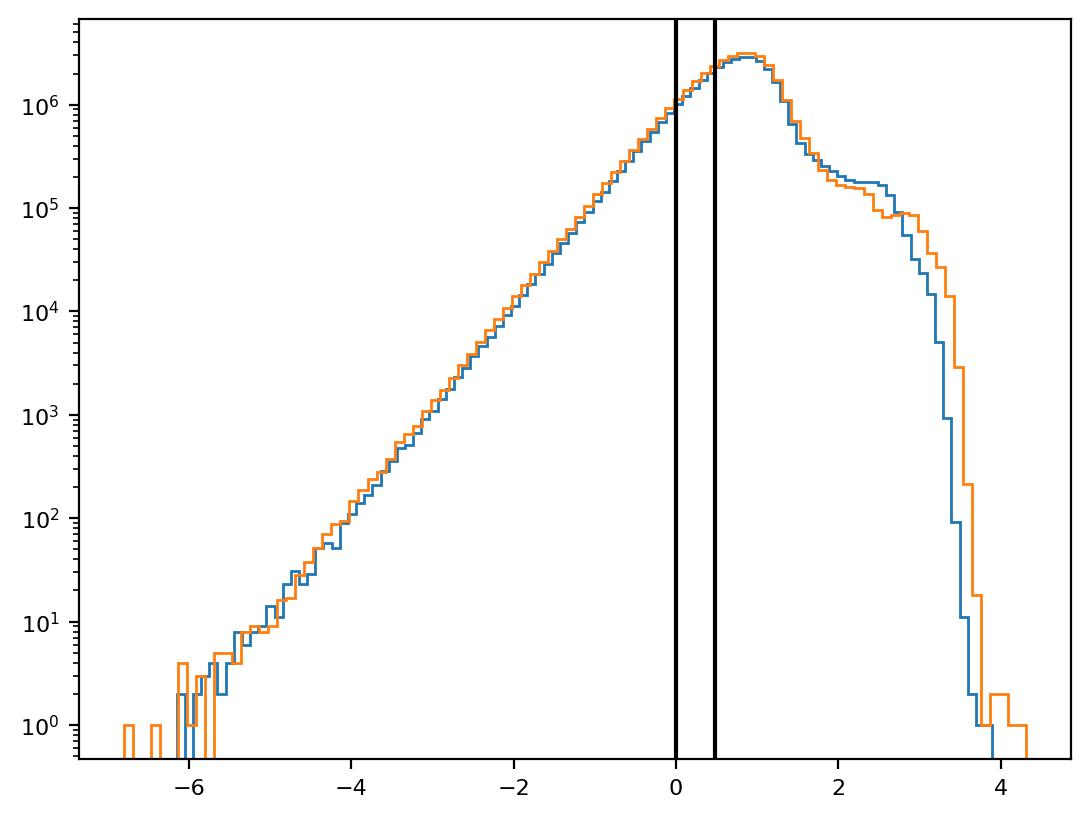

In [121]:
mask_bp = bp_snr>1
mask_rp = rp_snr>1
gmag_norm = 10**((15.-df['phot_g_mean_mag'].values)*0.4)

norm_bp = xp_coeff_array[0,:,:]/gmag_norm[:,None]
norm_rp = xp_coeff_array[2,:,:]/gmag_norm[:,None]

norm_bp = scaler_bp.transform(norm_bp)
norm_rp = scaler_rp.transform(norm_rp)

norm_bp_err = xp_coeff_array[1,:,:] / scaler_bp.scale_
norm_rp_err = xp_coeff_array[3,:,:] / scaler_rp.scale_

snr_bp_norm = np.abs(norm_bp/norm_bp_err)
snr_rp_norm = np.abs(norm_rp/norm_rp_err)


plt.hist(np.log10(snr_bp_norm.flatten()[snr_bp_norm.flatten()>0]), histtype='step', bins=100, log=True);
plt.hist(np.log10(snr_rp_norm.flatten()[snr_rp_norm.flatten()>0]), histtype='step', bins=100, log=True);
plt.axvline(x=np.log10(3), c='k')
plt.axvline(x=np.log10(1), c='k')

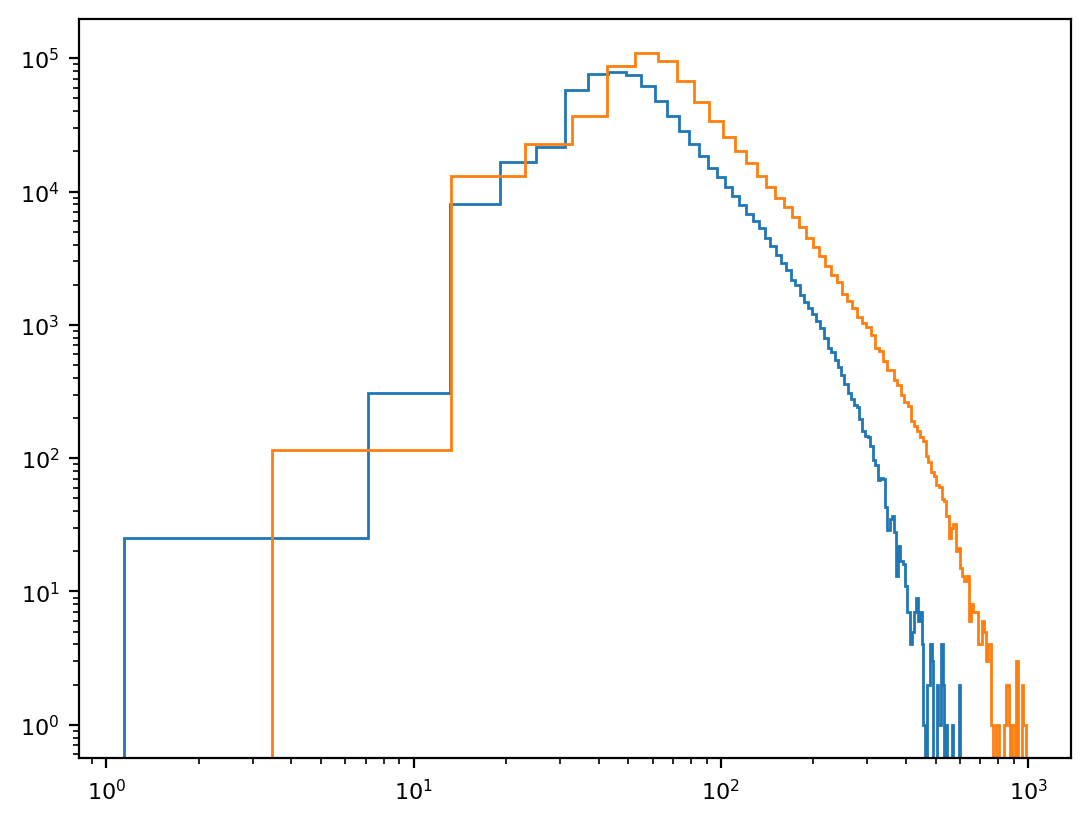

In [125]:


snr_bp_global = l2norm(xp_coeff_array[0,:,:])/l2norm(xp_coeff_array[1,:,:])
snr_rp_global = l2norm(xp_coeff_array[2,:,:])/l2norm(xp_coeff_array[3,:,:])


plt.hist(snr_bp_global, histtype='step', bins=100, log=True);
plt.hist(snr_rp_global, histtype='step', bins=100, log=True);
plt.xscale('log')

In [ ]:
save_data = {
    "x":np.c_[norm_bp, norm_rp],
    "x_mask":np.c_[bp_snr<1, rp_snr<1],
    "source_id":df['source_id'].values
}

data_dir = "/data/jdli/gaia/"
# fname = "tian_test54559.npy"
fname = "tian_test660675.npy"
np.save(data_dir+fname, save_data)

In [ ]:

# pred_dfs = pd.DataFrame()
    
# xp_coeff_array = np.zeros([4, len(df), 55])

# xp_chunks = pd.read_csv(
#     "/nfsdata/share/gaiaxp/gdr3_jdli_sid_xp_continuous_mean_spectrum.csv", 
#     chunksize=int(1e5), sep="|")

# # df = Table.read("/home/jdli/transpec/data/GaiaDR3_SID_G16.fits").to_pandas()

# save_dir = "/nfsdata/share/gaiaxp/"
# save_name = "xp_2tian.npy"


# for i,xp_chunk in tqdm(enumerate(xp_chunks)):
    
#     pred_df  = pd.merge(df, xp_chunk, left_on='source_id', right_on='source_id')
#     pred_dfs = pd.concat((pred_dfs, pred_df), axis='index')
#     print(len(pred_dfs))


# for col in coef_names:
#     pred_dfs[col] = recover_coef(pred_dfs[col])
    
# print(xp_coeff_array.shape)

In [ ]:
device = torch.device('cuda:1')
fold = 0
epoch = 250
n_enc = 11
n_outputs = 4
n_dim = 8
n_xp = 110
# model_dir = "/data/jdli/gaia/model/0303_attn/"
# save_point = f"sp2_4l_{fold}_ep{epoch}.pt"

# model = XPformer2(
#     n_xp, n_outputs, 
#     device=device, channels=n_dim
# ).to(device)


model_dir = "/data/jdli/gaia/model/0303_cnn/"
save_point = f"sp2_4l_{fold}_ep{epoch}.pt"
model = CNN(
    n_xp, n_outputs, 
).to(device)



model.load_state_dict(remove_prefix(torch.load(model_dir+save_point)))

def recover_scale_label(y_hat, e_y_hat,
                        scaler_name='../models/scaler_labels_0228.gz'):
    scaler_labels = joblib.load(scaler_name)
    y   = scaler_labels.inverse_transform(y_hat)
    e_y = e_y_hat * scaler_labels.scale_
    return y, e_y


def infer_4lbs_model(model, data_loader, transcale_method=recover_scale_label,
                     device=torch.device('cuda:1')):
    
    out_lst, e_out_lst = np.array([]), np.array([])
    id_lst = []

    with torch.no_grad():
        
        for data in tqdm(data_loader):
            
            x = data['x'][:,:n_xp]
            # output = model(x, data['x_mask'])
            output = model(x)
                
            out_lst   = np.append(out_lst,  output[:,:4].cpu().numpy())
            id_batch =  list(np.int64(data['id']))
            
            del output, data
            for idl in id_batch:
                id_lst.append(idl)

    out_lst = np.array(out_lst).reshape(-1,4)
    y, e_y = transcale_method(out_lst, out_lst)
    return {'labels':y, 'source_id':id_lst}



In [ ]:

data_dir = "/data/jdli/gaia/"
# tr_file = "tian_test54559.npy"
tr_file = "tian_test660675.npy"

gdata  = GXP_4lb_infer(
    data_dir+tr_file, device=device,
    part_train=False,
)

gloader = DataLoader(gdata, batch_size=2**10)
labels_infer = infer_4lbs_model(
    model, gloader, 
    device=device, 
    transcale_method=recover_scale_label,
)


pred_names   = ['teff_xpformer', 'logg_xpformer',  'moh_xpformer', 'aom_xpformer']
rdf = pd.DataFrame(np.c_[labels_infer['labels'], labels_infer['source_id']], 
                   columns=pred_names+['source_id'])
    # rdfs = rdf if i==0 else pd.merge(rdfs, rdf, on='source_id')
        
print(rdf.shape)


<AxesSubplot:ylabel='Frequency'>

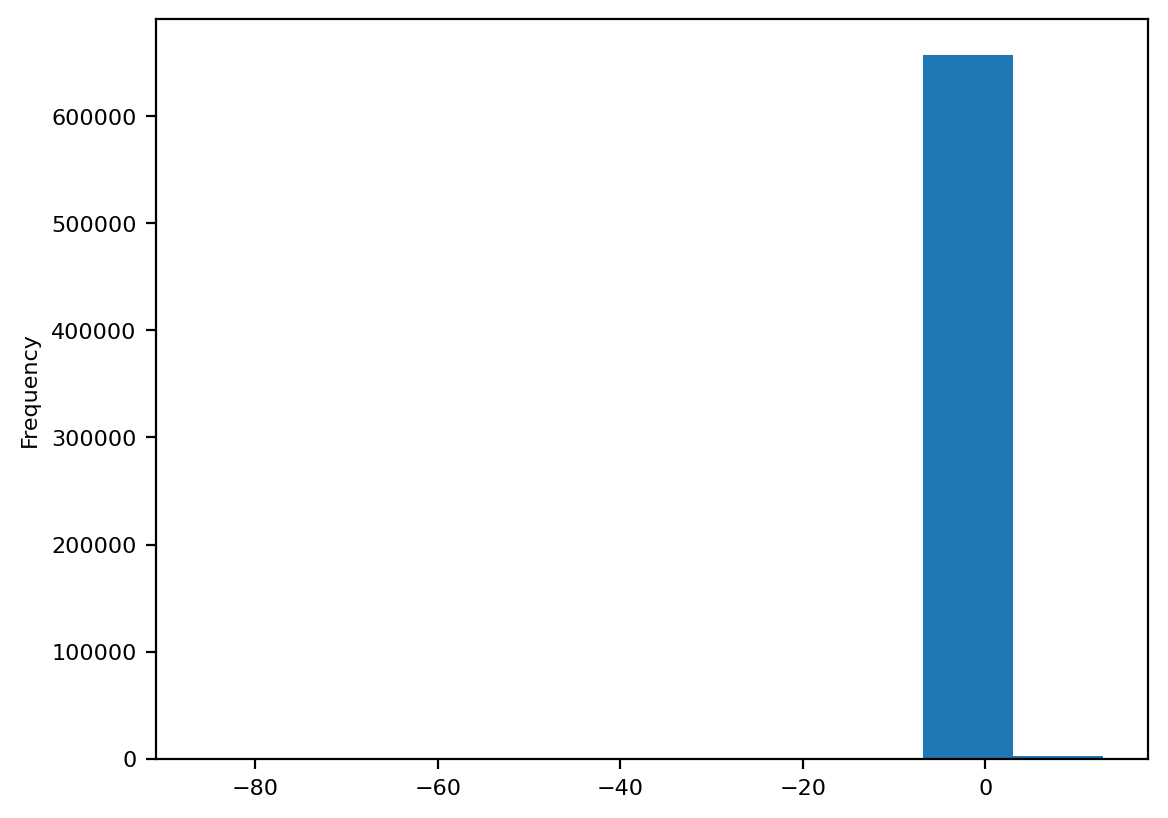

In [124]:
rdf['moh_xpformer'].plot(kind='hist')

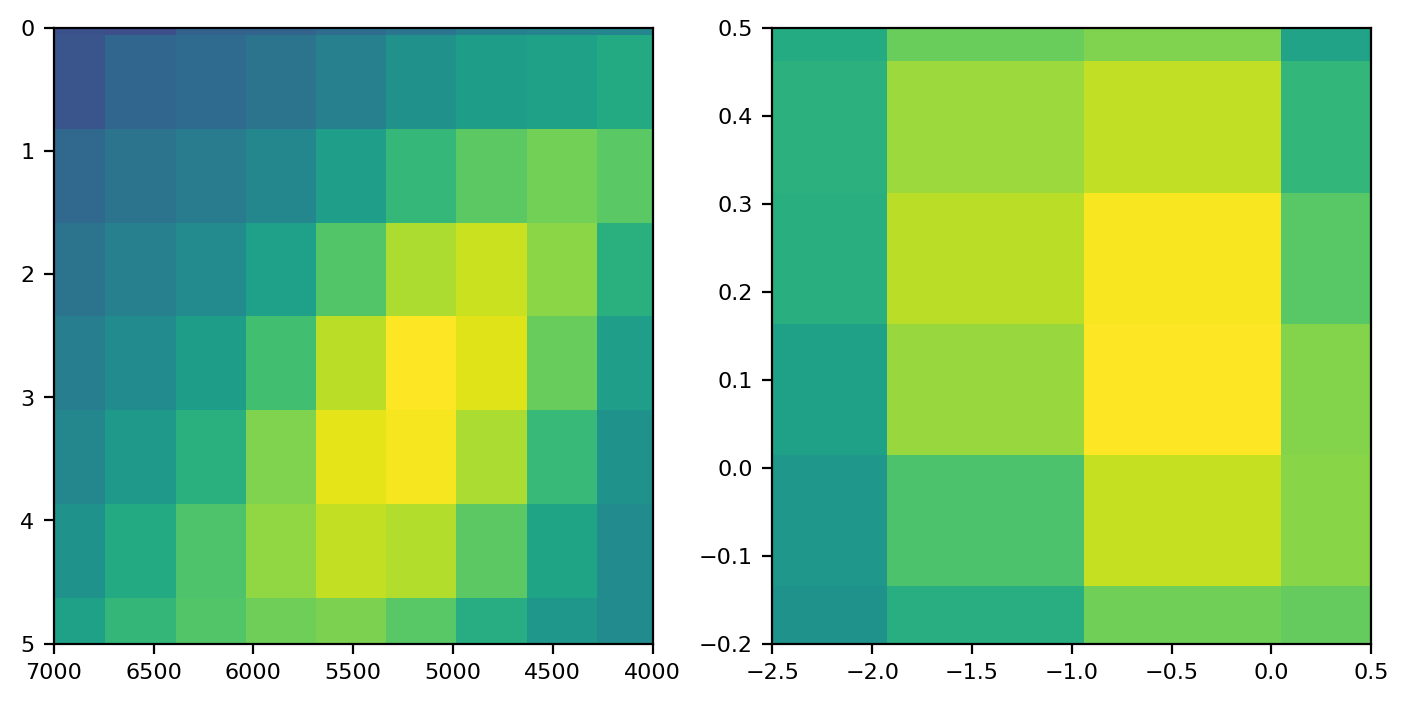

In [122]:
fig, axs = plt.subplots(1,2, figsize=(8.5, 4))

ax1, ax2 = axs.ravel()

ax1.hist2d(rdf['teff_xpformer'], rdf['logg_xpformer'], 
           bins=100, norm=colors.LogNorm());
ax2.hist2d(rdf['moh_xpformer'], rdf['aom_xpformer'], 
           bins=100, norm=colors.LogNorm());

ax1.set_xlim([7000, 4000]);
ax1.set_ylim([5, 0]);
ax1.set_xlabel("log g");
ax1.set_ylabel("Teff");
ax2.set_xlabel("[M/H]");
ax2.set_ylabel(r"[$\alpha/M$]");
ax2.set_xlim([-2.5, 0.5]);
ax2.set_ylim([-0.2, 0.5]);

In [108]:
rdf.to_csv("../data/tian_xpformerG16.csv")

In [123]:
rdf.shape

(660675, 5)